In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
#pip install -q pmdarima

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('fivethirtyeight')
import pathlib
import os
import seaborn as sns
import pandas as pd
from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
# import joblib
sns.set()

In [4]:
data = pd.read_csv('testset.csv')

In [5]:
data.head()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [6]:
data.tail()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
100985,20170424-06:00,Haze,17.0,0,0,NaN,25.0,NaN,1005.0,0,0,34.0,0,0,4.0,320.0,NW,NaN,NaN,11.1
100986,20170424-09:00,Haze,14.0,0,0,NaN,16.0,NaN,1003.0,0,0,38.0,0,0,4.0,320.0,NW,NaN,NaN,22.2
100987,20170424-12:00,Haze,12.0,0,0,NaN,14.0,NaN,1002.0,0,0,36.0,0,0,4.0,270.0,West,NaN,NaN,18.5
100988,20170424-15:00,Haze,15.0,0,0,NaN,27.0,NaN,1004.0,0,0,32.0,0,0,2.0,320.0,NW,NaN,NaN,3.7
100989,20170424-18:00,Haze,15.0,0,0,NaN,30.0,NaN,1005.0,0,0,30.0,0,0,2.0,320.0,NW,NaN,NaN,3.7


In [7]:
def overViewOfTheData(data,frows=5,lrows=5):
  print("Shape: ",data.shape,"\n\n")
  
  print("Columns: ",data.columns,"\n\n")

  print("Info : ")
  print(data.info())

In [8]:
overViewOfTheData(data)

Shape:  (100990, 20) 


Columns:  Index(['datetime_utc', ' _conds', ' _dewptm', ' _fog', ' _hail',
       ' _heatindexm', ' _hum', ' _precipm', ' _pressurem', ' _rain', ' _snow',
       ' _tempm', ' _thunder', ' _tornado', ' _vism', ' _wdird', ' _wdire',
       ' _wgustm', ' _windchillm', ' _wspdm'],
      dtype='object') 


Info : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100990 entries, 0 to 100989
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   datetime_utc  100990 non-null  object 
 1    _conds       100918 non-null  object 
 2    _dewptm      100369 non-null  float64
 3    _fog         100990 non-null  int64  
 4    _hail        100990 non-null  int64  
 5    _heatindexm  29155 non-null   float64
 6    _hum         100233 non-null  float64
 7    _precipm     0 non-null       float64
 8    _pressurem   100758 non-null  float64
 9    _rain        100990 non-null  int64  
 10   _snow        100990 

Text(0, 0.5, 'Features')

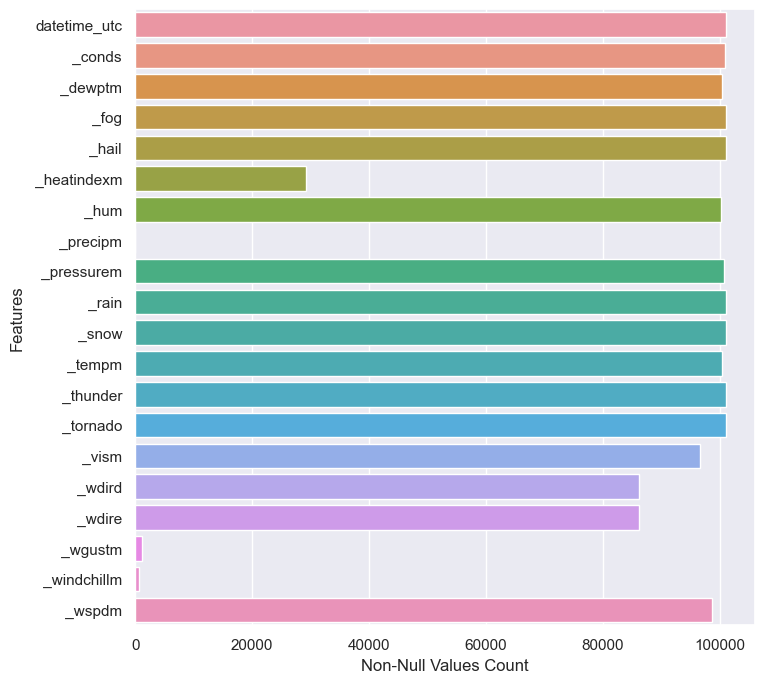

In [9]:
plt.figure(figsize=(8,8))
sns.barplot(x=data.count()[:],y=data.count().index)
plt.xlabel('Non-Null Values Count')
plt.ylabel('Features')

Many of the features have a lot of missing values

We will remove those features which are having a lot of missing values (heatindexm, precipm, wgustm & windchillm) 

& we will try to fill missing values in the rest of the features

We can see there are some missing values in temp also.

In [10]:
data = data.drop([' _heatindexm',' _precipm',' _wgustm',' _windchillm'],axis=1)

Pre-processing and EDA

In [11]:
# Date-Time column is not in the desired format. So, first we will convert it into the desired format (yyyy-mm-dd HH:MM)
# And the we will make that column the index of the data

data['datetime_utc'] = pd.to_datetime(data['datetime_utc'].apply(lambda x: datetime.strptime(x,"%Y%m%d-%H:%M").strftime("%Y-%m-%d %H:%M")))
data['datetime_utc'].head()

0   1996-11-01 11:00:00
1   1996-11-01 12:00:00
2   1996-11-01 13:00:00
3   1996-11-01 14:00:00
4   1996-11-01 16:00:00
Name: datetime_utc, dtype: datetime64[ns]

In [12]:
data = data.set_index('datetime_utc',drop=True)
data.index.name = 'datetime'

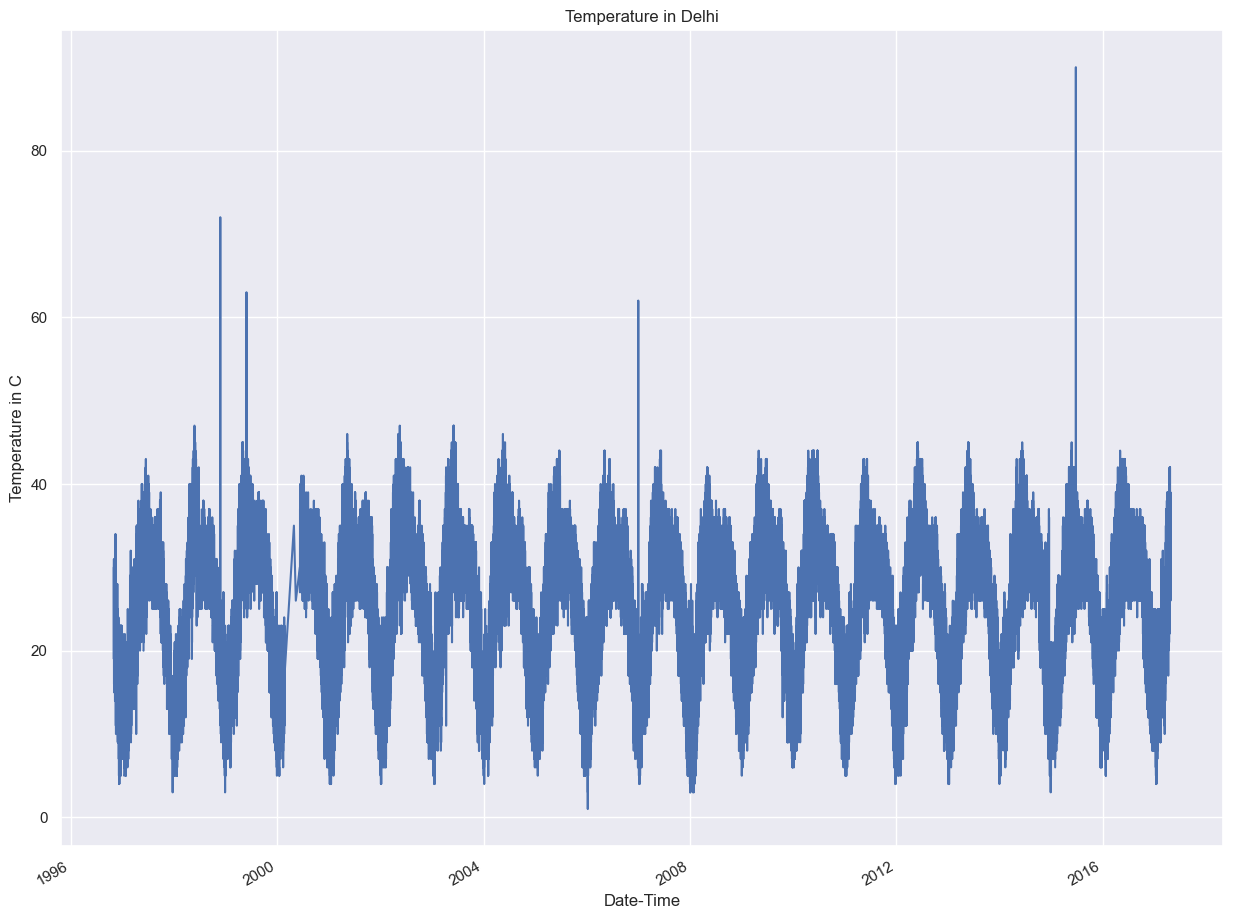

In [13]:
fig, ax = plt.subplots()
data[' _tempm'].plot(figsize=(15,12),ax=ax)
ax.set_xlabel('Date-Time')
ax.set_ylabel('Temperature in C')
ax.set_title('Temperature in Delhi')
plt.show()

We can see a seasonal pattern in the timeseries

It is also not continuous as it is having some missing data (ex: between 2000 and 2001)

This could be a problem while modeling the timeseries. So, to avoid this we will train our model on the data from the year 2001

as we have enough data for training and there is no significant trend that we will miss by dropping the data before 2001

We have some OUTLIERS in the series also as we can see some really high temperature values. We will remove these outliers.

We have large amount of data but we will only use the necessary data (2013-2016)



In [14]:
# Dropping the data before 2001
data = data['2001':]

In [15]:
# We will remove the missing data and later we will interpolate the temperature for that missing data
print("Before : ", data.shape)
data.dropna(subset=[' _tempm'],inplace=True)
print("After :", data.shape)

Before :  (77929, 15)
After : (77474, 15)


In [16]:
data.index.minute.value_counts()

0     46991
30    30276
21      143
51       29
50       15
25        3
40        3
38        3
20        2
2         1
45        1
22        1
53        1
52        1
3         1
15        1
34        1
32        1
Name: datetime, dtype: int64

Here we can see we have irregular time-intervals

So we will remove the minute time-stamp and will only consider the hourly data

In [17]:
categoricalColumns = list(set(data.columns) - set(data._get_numeric_data().columns))
categoricalColumns

[' _wdire', ' _conds']

In [18]:
# We are resampling it by hours & filling the missing values using the interpolation method
# Notice here we will only get numeric columns so we will have to add the categorical columns additionaly
newdata = data.resample('H').mean().interpolate()
newdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 142987 entries, 2001-01-01 00:00:00 to 2017-04-24 18:00:00
Freq: H
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0    _dewptm     142987 non-null  float64
 1    _fog        142987 non-null  float64
 2    _hail       142987 non-null  float64
 3    _hum        142987 non-null  float64
 4    _pressurem  142987 non-null  float64
 5    _rain       142987 non-null  float64
 6    _snow       142987 non-null  float64
 7    _tempm      142987 non-null  float64
 8    _thunder    142987 non-null  float64
 9    _tornado    142987 non-null  float64
 10   _vism       142987 non-null  float64
 11   _wdird      142987 non-null  float64
 12   _wspdm      142987 non-null  float64
dtypes: float64(13)
memory usage: 15.3 MB


C:\Users\Leobardo\AppData\Local\Temp\ipykernel_17208\421637353.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  newdata = data.resample('H').mean().interpolate()


In [19]:
# To resample the categorical data we will consider the firt observation and to fill the missing values we will use ffill method
newdata[list(categoricalColumns)] = data[categoricalColumns].resample('H').first().ffill().head()
newdata.head()

,_dewptm,_fog,_hail,_hum,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wspdm,_wdire,_conds
datetime,,,,,,,,,,,,,,,
2001-01-01 00:00:00,13.0,0.0,0.0,94.0,1011.0,0.0,0.0,14.0,0.0,0.0,1.4,90.0,9.3,East,Scattered Clouds
2001-01-01 01:00:00,12.0,0.0,0.0,94.0,1011.0,0.0,0.0,13.0,0.0,0.0,1.3,70.0,11.1,ENE,Scattered Clouds
2001-01-01 02:00:00,12.0,0.0,0.0,94.0,1012.0,0.0,0.0,13.0,0.0,0.0,1.3,50.0,13.0,NE,Mostly Cloudy
2001-01-01 03:00:00,13.0,0.0,0.0,100.0,1013.0,1.0,0.0,13.0,1.0,0.0,1.0,140.0,5.6,SE,Light Thunderstorms and Rain
2001-01-01 04:00:00,12.0,0.0,0.0,94.0,1014.0,1.0,0.0,13.0,1.0,0.0,1.0,110.0,7.4,ESE,Light Thunderstorms and Rain


In [20]:
def plotAggregateValues(data,column=None):
  if column in data.columns:
    plt.figure(figsize = (18,25))
    
    ax1 = plt.subplot(4,2,1)
    newdata[column].groupby(newdata.index.year).mean().plot(ax=ax1,title='yearly mean values')
    ax1.set_xlabel('years')
    ax1.set_ylabel(column)
  
    ax2 = plt.subplot(4,2,2)
    newdata[column].groupby(newdata.index.month).mean().plot(ax=ax2,title='monthly mean values')
    ax2.set_xlabel('months')
    ax2.set_ylabel(column)

    # ax3 = plt.subplot(4,2,3)
    # newdata[column].groupby(newdata.index.weekday).mean().plot(ax=ax3,title='weekdays mean values')
    # ax3.set_xlabel('weekdays')
    # ax3.set_ylabel(column)

    ax4 = plt.subplot(4,2,4)
    newdata[column].groupby(newdata.index.hour).mean().plot(ax=ax4,title='hourly mean values')
    ax4.set_xlabel('hours')
    ax4.set_ylabel(column)

    # ax5 = plt.subplot(4,2,5)
    # newdata[column].groupby(newdata.index.minute).mean().plot(ax=ax5,title='minute wise mean values')
    # ax5.set_xlabel('minutes')
    # ax5.set_ylabel(column)

    # ax6 = plt.subplot(4,2,6)
    # newdata[column].groupby(newdata.index.second).mean().plot(ax=ax6,title='seconds wise mean values')
    # ax6.set_xlabel('seconds')
    # ax6.set_ylabel(column)

  else:
    print("Column name not specified or Column not in the data")

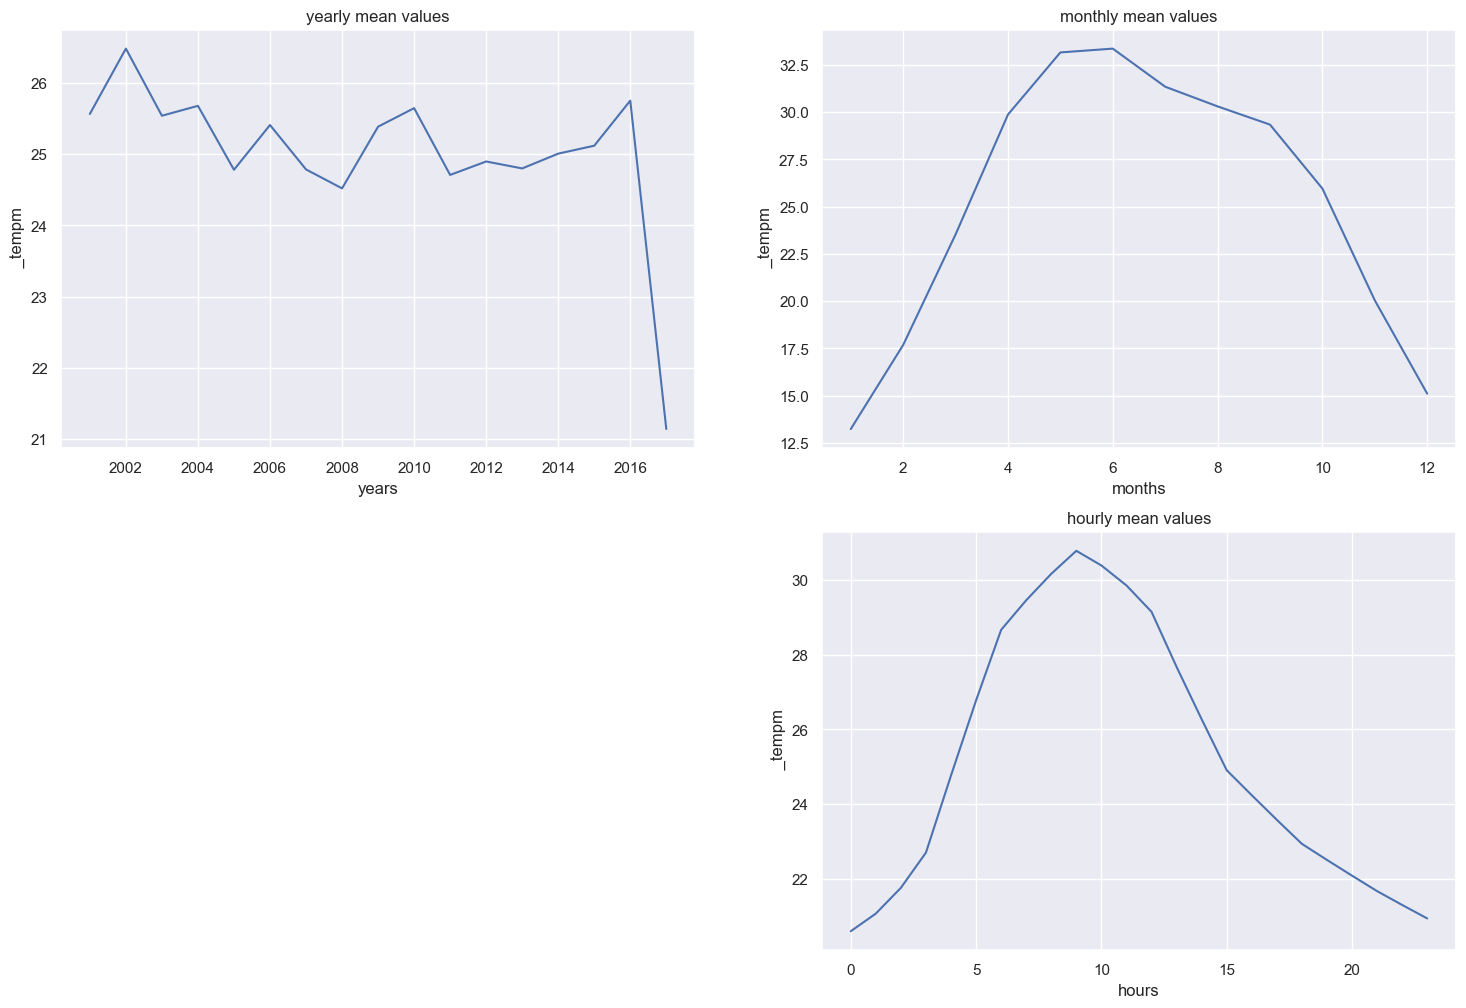

In [21]:
plotAggregateValues(newdata,' _tempm')

We can see highest temperature during 5th & 6th month as it is summer time and low temperature during the end and start of the year because of winter.

Also, there is high temperature during 11-13 hours as it is noon time and low temperature during night hours.

In [22]:
def plotBoxNdendity(data,col=None):
  if col in data.columns:    
    plt.figure(figsize=(18,8))

    ax1 = plt.subplot(121)
    data.boxplot(col,ax=ax1)
    ax1.set_ylabel('Boxplot temperature levels in Delhi', fontsize=10)

    ax2 = plt.subplot(122)
    data[col].plot(ax=ax2,legend=True,kind='density')
    ax2.set_ylabel('Temperature distribution in Delhi', fontsize=10)

  else:
    print("Column not in the data")

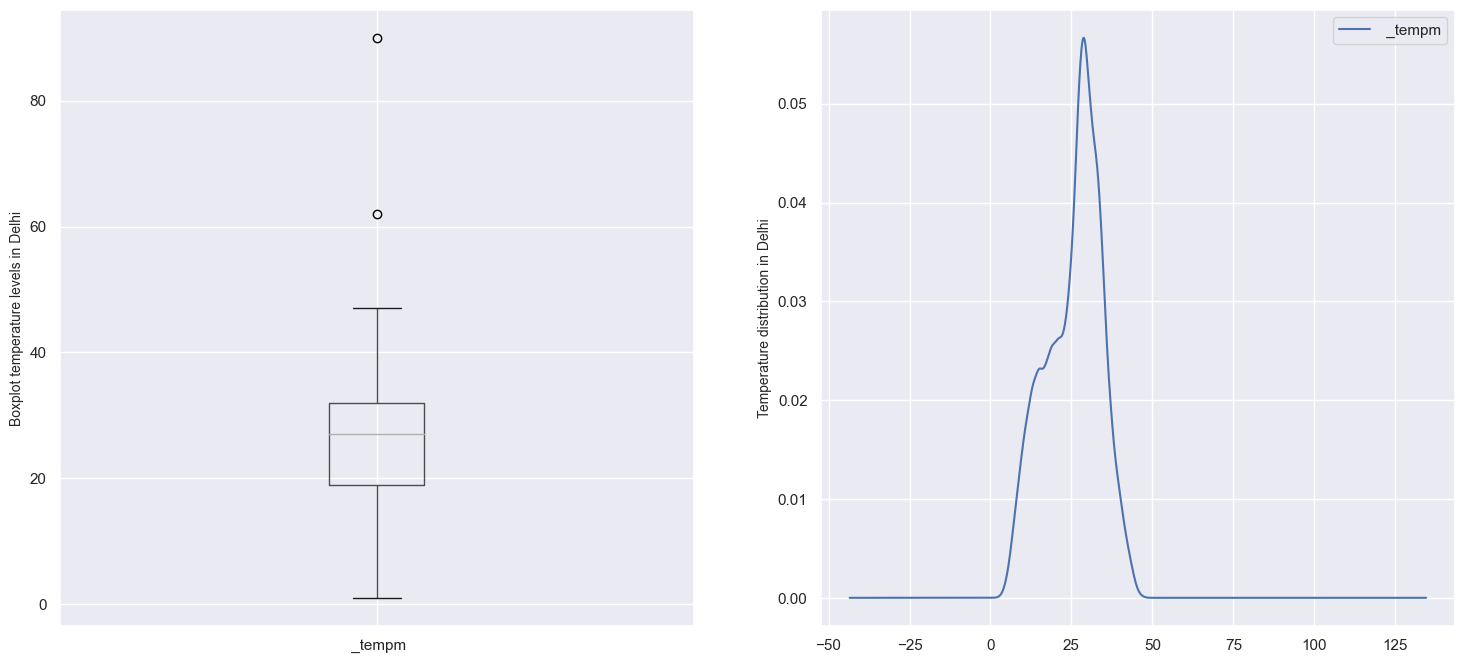

In [23]:
plotBoxNdendity(data,' _tempm')

We can observe outliers in box plot which are extremely high.

50% of the temperature values are distributed around ~26 C



Train & Test Split

In [24]:
train = newdata[:'2015']
test = newdata['2016':]

Model Building

1. Identification

In [25]:
# Let's decompose the time series to visualize trend, season and noise seperately
def decomposeNplot(data):
  decomposition = sm.tsa.seasonal_decompose(data)

  plt.figure(figsize=(15,16))

  ax1 = plt.subplot(411)
  decomposition.observed.plot(ax=ax1)
  ax1.set_ylabel('Observed')

  ax2 = plt.subplot(412)
  decomposition.trend.plot(ax=ax2)
  ax2.set_ylabel('Trend')

  ax3 = plt.subplot(413)
  decomposition.seasonal.plot(ax=ax3)
  ax3.set_ylabel('Seasonal')

  ax4 = plt.subplot(414)
  decomposition.resid.plot(ax=ax4)
  ax4.set_ylabel('Residuals')

  return decomposition

In [26]:
# Resampling the data to mothly and averaging out the temperature & we will predict the monthly average temperature
ftraindata = train[' _tempm'].resample('M').mean()
ftestdata = test[' _tempm'].resample('M').mean()

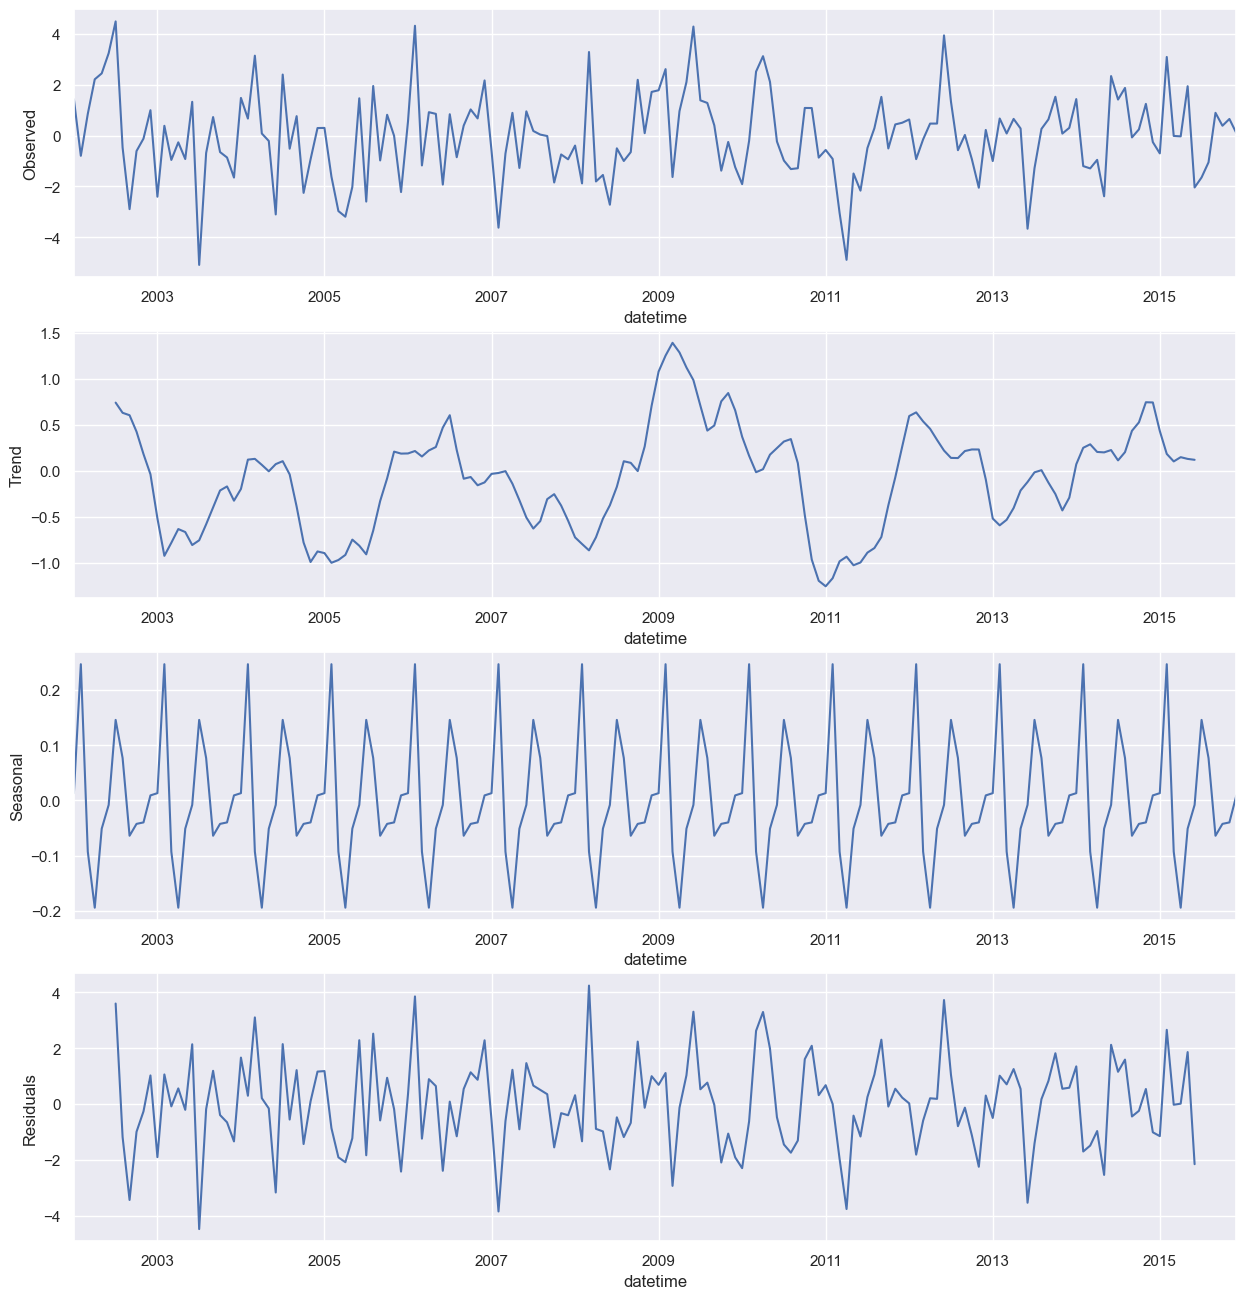

In [27]:
# Taking the seasonal difference S=12 and decomposing the timeseries
decomposition = decomposeNplot(ftraindata.diff(12).dropna())

Stationary?

In [28]:
# Let's check for stationarity (Augmented Dickey Fuller test)
results = adfuller(ftraindata.diff(12).dropna())
results

(-6.34375831581013,
 2.714508655047363e-08,
 11,
 156,
 {'1%': -3.4729792729247793,
  '5%': -2.8802520918255534,
  '10%': -2.5767469641683105},
 530.2085130736691)

p-value is less than 0.05 and test-statistic is also less very -ev

So we can say the series is stationary and we can model it without any further transforms



Seasonal?

We observed before that there is a yearly periodic pattern -> Seasonal


Order of the model?

C:\Users\Leobardo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


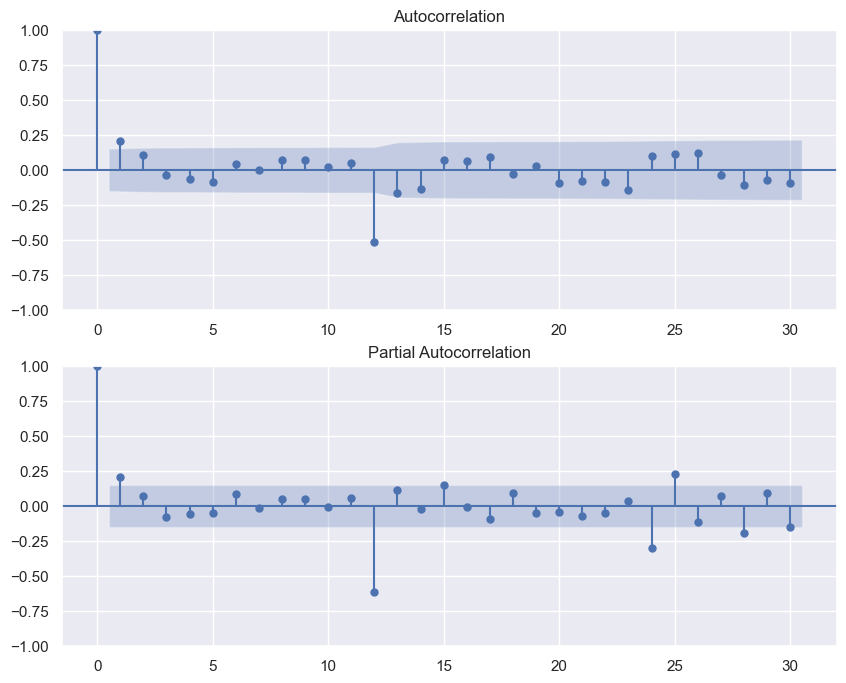

In [29]:
# To get non-seasonal oreders of the SARIMAX Model we will first use ACF & PACF plots
plt.figure(figsize=(10,8))

ax1 = plt.subplot(211)
acf = plot_acf(ftraindata.diff(12).dropna(),lags=30,ax=ax1)

ax2 = plt.subplot(212)
pacf = plot_pacf(ftraindata.diff(12).dropna(),lags=30,ax=ax2)

It's hard to get the idea of the non-seasonal orders from these plots

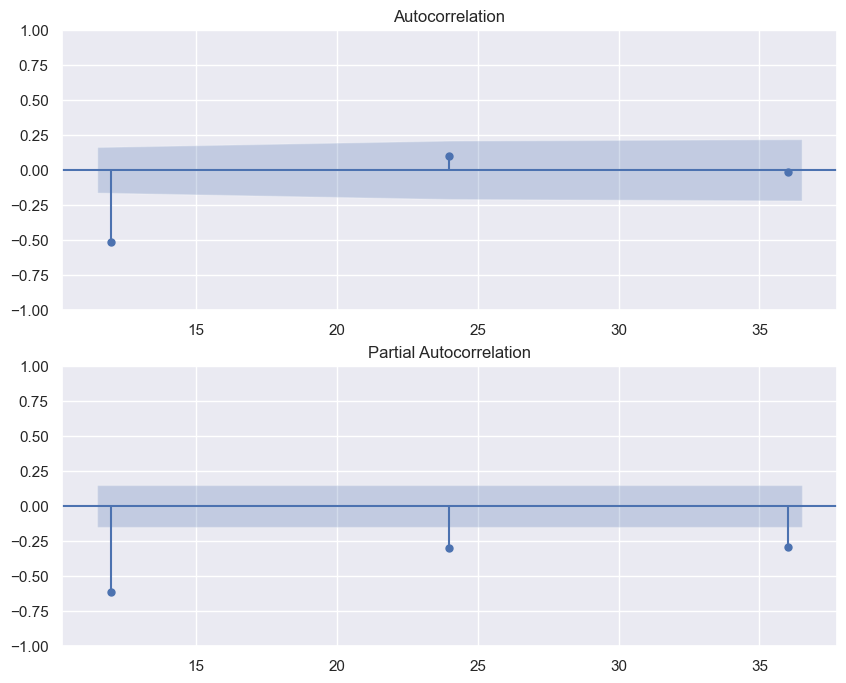

In [30]:
# To get seasonal oreders of the SARIMAX Model we will first use ACF & PACF plots at seasonal lags 

lags = [12*i for i in range(1,4)]

plt.figure(figsize=(10,8))

ax1 = plt.subplot(211)
acf = plot_acf(ftraindata.diff(12).dropna(),lags=lags,ax=ax1)

ax2 = plt.subplot(212)
pacf = plot_pacf(ftraindata.diff(12).dropna(),lags=lags,ax=ax2)

As ACF cuts off after lag 1 & PACF is trailing off we can say that the order of seasonal MA is 1 (Q=1)

2. Estimation

In [31]:
model = SARIMAX(ftraindata,order=(0,0,1),seasonal_order=(0,1,1,12),trend='n')
results = model.fit()

Automatic Model Selection

In [32]:
# # Lets select the best model based on the aic & bic scores using auto_arima
# results = pm.auto_arima(ftraindata,
#                       seasonal=True, m=12,
#                       d=0,D=1,trace=True,
#                       error_action='ignore',
#                       suppress_warnings=True)

3. Diagnostics

In [33]:
# Check the value of Prob(Q) if it is > 0.05 => The residuals are uncorrelated
# Similarly if Prob(JB) > 0.05 => The residuals are normally distributed
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             _tempm   No. Observations:                  180
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -278.353
Date:                            Sun, 24 Sep 2023   AIC                            562.706
Time:                                    12:22:31   BIC                            572.078
Sample:                                01-31-2001   HQIC                           566.510
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2785      0.063      4.400      0.000       0.154       0.403
ma.S.L12      -0.8880      0.101     -8.833      0.000      -1.085      -0.691
sigma2         1.4426      0.183      7.889      0.000       1.084       1.801
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.11
Prob(Q):                              0.92   Prob(JB):                         0.57
Heteroskedasticity (H):               0.53   Skew:                             0.20
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
# Mean Absolute Error for training data
print(np.mean(np.abs(results.resid)))

2.65280323918259


~3 *C monthly average temperature error

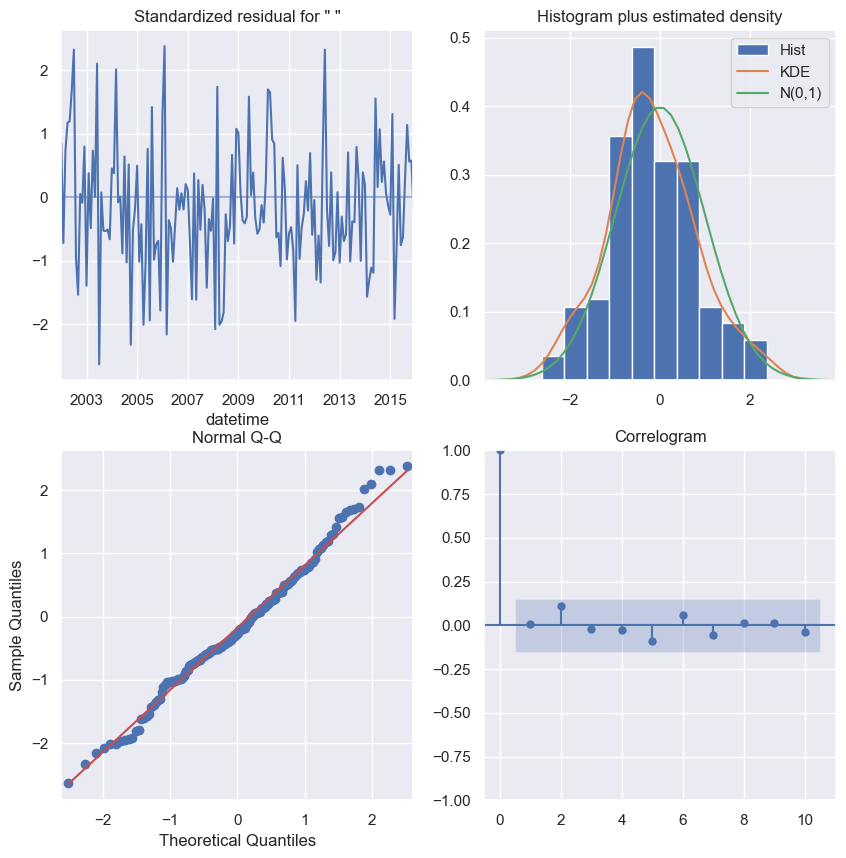

In [35]:
diagnostics = results.plot_diagnostics(figsize=(10,10))

Here we can see: 

* Standardized residual plot: No obvious structure (ok)
* Histogram & KDE: KDE is normally distributed (ok)
* Normal Q-Q: Almost all the points are on the red line (ok)
* Correlogram of residuals: is nearly zero for all lags (ok)

4. Forecasting

In [36]:
forecast = results.get_forecast(steps=len(ftestdata))

In [37]:
predictedmean = forecast.predicted_mean
bounds = forecast.conf_int()
lower_limit = bounds.iloc[:,0]
upper_limit = bounds.iloc[:,1]

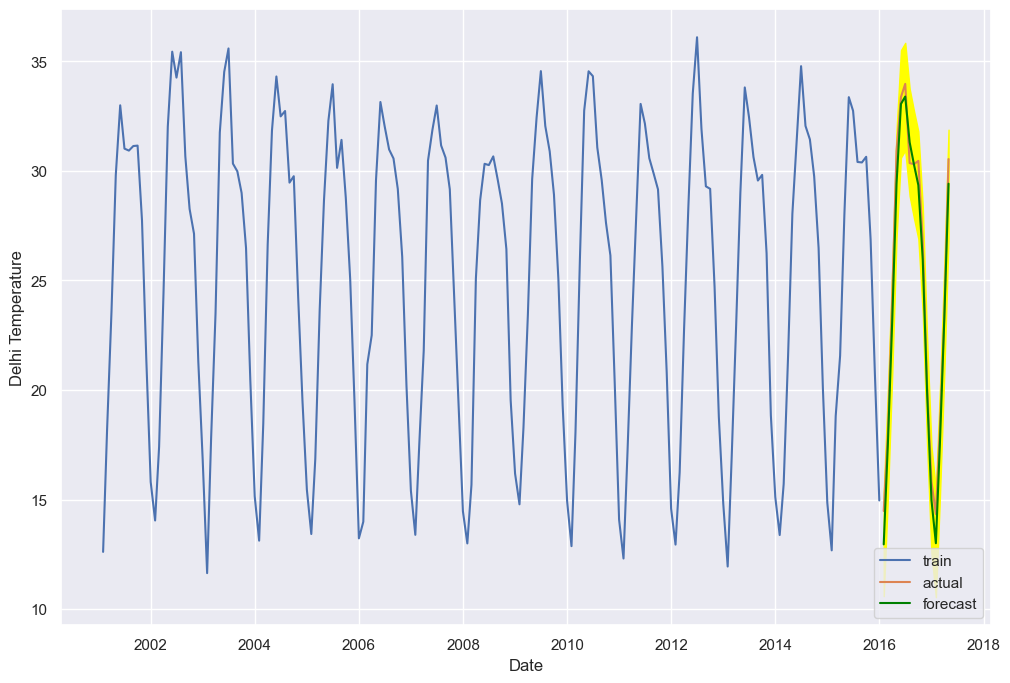

In [38]:
plt.figure(figsize=(12,8))

plt.plot(ftraindata.index, ftraindata, label='train')
plt.plot(ftestdata.index,ftestdata,label='actual')

plt.plot(predictedmean.index, predictedmean, color='green', label='forecast')

plt.fill_between(lower_limit.index,lower_limit,upper_limit, color='yellow')

plt.xlabel('Date')
plt.ylabel('Delhi Temperature')
plt.legend()
plt.show()

5. Saving the model